In [1]:
import HT_control_packagecf as ctrl
import CFmodel
import HT_generate_trajectory as trajgen_thinh
import get_solver_cmpc as cmpc
import numpy as np
import yaml
## Load parameters from config file
with open('Config_Crazyflie_V2.yaml') as f:
    system_parameters = yaml.load(f,Loader=yaml.FullLoader)

qtm_ip = system_parameters['qtm_ip']
Ts = system_parameters['Ts']
Tsim = system_parameters['Tsim']
m = system_parameters['mass']
uris = system_parameters['uris']
drone_bodies = system_parameters['drone_bodies']

## Load Trajectories for drones:
# ref = {}
# vref = {}
# full_ref1 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=1)
# full_ref2 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=2)
# full_ref3 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=3)

# full_ref1 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=11)
# full_ref2 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=12)
# full_ref3 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=13)
# ref = {uris[0]: full_ref1["trajectory"],
#        uris[1]: full_ref2["trajectory"],
#       uris[2]: full_ref3["trajectory"]} 

# vref = {uris[0]: full_ref1["v_ref"],
#         uris[1]: full_ref2["v_ref"],
#         uris[2]: full_ref3["v_ref"]}

# print(np.size(ref[uris[0]],1))
# vref[uris[0]] = np.zeros((np.size(ref[uris[0]],0),3))
# vref[uris[1]] = np.zeros((np.size(ref[uris[1]],0),3))
# vref[uris[2]] = np.zeros((np.size(ref[uris[2]],0),3))


ptf = './Trajectory/traj4UAVs_Vincent3.mat'
full_ref = trajgen_thinh.get_trajectory_mat(path_to_file=ptf,dt=Ts)

ref = {}

vref = {}
for i in range(len(drone_bodies)):
    ref[uris[i]] = full_ref[i]["trajectory"]

    vref[uris[i]] = full_ref[i]["v_ref"]



In [11]:
common_plant,common_controller = cmpc.load_constant_parameters(Ts=Ts)
drone_params = {}
for i in range(len(drone_bodies)):
    drone_params[i] = cmpc.droneParameters(drone_address=uris[i],body_name=drone_bodies[i],mass=m[i],
                                                         plant=common_plant,controller=common_controller) 

central_plant,central_controller,simulator = cmpc.get_stacked_drones_parameters(list_of_drones=drone_params)
simulator['Nsim'] = np.size(ref[uris[0]],0)
# CMPC_solver,CMPC_solver_variables = cmpc.get_solver_cmpc(plant=central_plant,controller=central_controller,simulator=simulator)


simulator['u_sim'] = np.zeros((common_plant['du'],simulator['Nsim'],simulator['na']))
simulator['x_sim'] = np.zeros((common_plant['dx'],simulator['Nsim']+1,simulator['na']))

for i in range(simulator['na']):
    simulator['u_sim'][:,:,i] = np.zeros((common_plant['du'],simulator['Nsim']))
    simulator['x_sim'][:,0,i] = ref[uris[i]][0,:].T 

In [12]:
import get_solver_CBFQP as cbfqp
solver = {}
dc=0.1
a1=6
a2=8
for i in range(len(drone_bodies)):
    solver[drone_bodies[i]] = cbfqp.CBFQPSolver(v_ref0=vref[uris[i]][0,:],
                                             x_ref0=ref[uris[i]][0,:],
                                             x0=simulator['x_sim'][:,0,i],
                                             a1=a1, a2=a2,dc=dc)
    res = solver[drone_bodies[i]].prob.solve()
    res = solver[drone_bodies[i]].prob.solve()
    res = solver[drone_bodies[i]].prob.solve()
    print(res.x)


[ 1.17668358e-04  3.28507105e-04 -7.52526496e-05]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[ 1.17668358e-04  3.28507105e-04 -7.52526496e-05]
[ 3.27085059e-04 -2.95150330e-05  1.19998493e-04]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[ 3.27085059e-04 -2.95150330e-05  1.19998493e-04]
[0.0001516  0.00017709 0.00021859]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0.0001516  0.00017709 0.00021859]
[-0.00020047  0.00013682  0.00021601]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[-0.00020047  0.00013682  0.00021601]


In [8]:
k = 0
Kf = {}
for i in range(len(drone_bodies)):
    Kf[uris[i]]  =  -2.0 *  np.array([[2.5, 0, 0, 1.5, 0, 0],
                                    [0, 2.5, 0, 0, 1.5, 0],
                                    [0, 0, 2.5, 0, 0, 1.5]]) #gain matrix obtained from LQR
import time 
start = time.perf_counter()
while(k< simulator['Nsim']):
    tic = time.perf_counter()
    # if k==0:
    #     u_init = np.zeros((central_plant['du'],1))
    # else:
    #     u_init = simulator['U_total'][:,k-1]
    
    # simulator['X_ref'] = cmpc.get_ref_pred_horz(ref=ref,k=k,Npred=common_controller['Npred']+1,uris=uris)
    # simulator['v_ref'] = cmpc.get_ref_pred_horz(ref=vref,k=k,Npred=common_controller['Npred'],uris=uris)
    # for i in range(simulator['na']):
    #     simulator['X_total'][i*(common_plant['dx']):(i+1)*(common_plant['dx']),k] = simulator['x_sim'][:,k,i]
    
    # simulator['U_total'][:,k] = cmpc.compute_control_cmpc(solver=CMPC_solver,solver_variables=CMPC_solver_variables,X0=simulator['X_total'][:,k],
    #                           v0=u_init,Xrefk=simulator['X_ref'],vrefk = simulator['v_ref'],yawk = 0)
    controls = {}
    for i in range(simulator['na']):
        # simulator['u_sim'][:,k,i] = simulator['U_total'][i*(common_plant['du']):(i+1)*(common_plant['du']),k]
        solver[drone_bodies[0]].update(v_ref=vref[uris[0]][k,:],
                     x_ref=ref[uris[0]][k,:],
                    x=simulator['x_sim'][:,k,0],)
        res = solver[drone_bodies[0]].prob.solve()
        simulator['u_sim'][:,k,i] = res.x + ctrl.compute_control(v_ref=vref[uris[i]][k,:],
                                                                 x0=simulator['x_sim'][:,k,i],
                                                                 xref=ref[uris[i]][k,:],
                                                                 Kf=Kf[uris[i]])
        # compute real control u
        controls[uris[i]] = ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)
        
        # disturbance
        disturb = np.zeros((1,3))
        disturb = disturb + np.random.normal(loc=0.0,scale=0.3,size=(1,3))
        simulator['x_sim'][:,k+1,i] = CFmodel.CFmodel(xk=simulator['x_sim'][:,k,i],urk= controls[uris[i]],plant=common_plant,disturb=disturb)

    k = k+1 
    
    print(f'{time.perf_counter()-tic} sec')
end = time.perf_counter()
calcul_t = end-start


print('Calulation time : ',calcul_t)
print('Average calculation time : ',calcul_t/simulator['Nsim'])

9.80992
9.81012
9.81022
9.81022
0.0028808409988414496 sec
9.93524
9.79481
9.70261
9.66179
0.0020081260008737445 sec
10.05518
9.82014
9.81857
9.66685
0.001240883007994853 sec
10.05373
9.76886
9.80585
9.76464
0.0012618929904419929 sec
9.80943
9.67375
9.89611
9.81711
0.0008839499932946637 sec
9.59295
9.6687
9.70915
9.81787
0.001050749997375533 sec
9.65575
9.80255
9.71269
9.62922
0.001579067000420764 sec
9.56908
9.67274
9.9081
9.6214
0.0020305219950387254 sec
9.45012
9.84318
9.96782
9.70455
0.0024200629995903 sec
9.43991
9.82509
9.87545
9.91063
0.004633037999155931 sec
9.65875
10.00236
9.83002
9.87616
0.002867507006158121 sec
9.81316
10.16954
9.82713
9.91841
0.0019612930045695975 sec
9.80627
9.95964
9.82913
10.07604
0.0015143560012802482 sec
9.73439
9.8612
9.74379
10.0293
0.0011530320043675601 sec
9.82597
10.08634
9.78581
10.06397
0.0015732020110590383 sec
9.81654
10.04896
9.93874
10.03107
0.002491085004294291 sec
9.74892
10.13704
10.00331
9.88543
0.0019468980026431382 sec
9.74695
10.02365

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


9.80992
9.81012
9.81022
9.81022
9.93524
9.79481
9.70261
9.66179
10.05518
9.82014
9.81857
9.66685
10.05373
9.76886
9.80585
9.76464
9.80943
9.67375
9.89611
9.81711
9.59295
9.6687
9.70915
9.81787
9.65575
9.80255
9.71269
9.62922
9.56908
9.67274
9.9081
9.6214
9.45012
9.84318
9.96782
9.70455
9.43991
9.82509
9.87545
9.91063
9.65875
10.00236
9.83002
9.87616
9.81316
10.16954
9.82713
9.91841
9.80627
9.95964
9.82913
10.07604
9.73439
9.8612
9.74379
10.0293
9.82597
10.08634
9.78581
10.06397
9.81654
10.04896
9.93874
10.03107
9.74892
10.13704
10.00331
9.88543
9.74695
10.02365
10.0617
9.74135
9.95264
9.92431
9.91492
9.82456
9.99581
9.73621
9.90255
9.67579
10.06293
9.81445
9.88798
9.65943
10.15585
9.68354
10.04467
9.93505
10.07413
9.68107
10.10103
9.98043
9.9865
9.62109
10.07055
9.96983
9.93021
9.56081
9.95403
9.98049
9.78478
9.5073
9.94198
9.91024
9.83928
9.58918
10.09812
9.87449
9.88009
9.5781
9.89872
9.78324
9.85368
9.64134
9.87649
9.74623
9.6775
9.76099
9.99527
9.69799
9.7577
9.6994
10.02407
9.6157

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


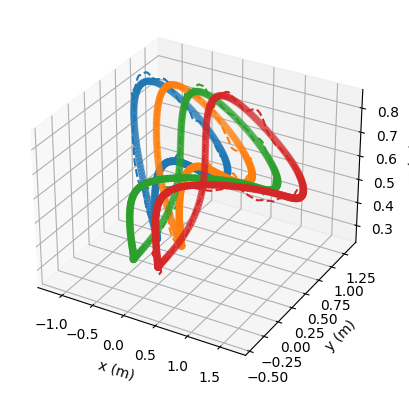

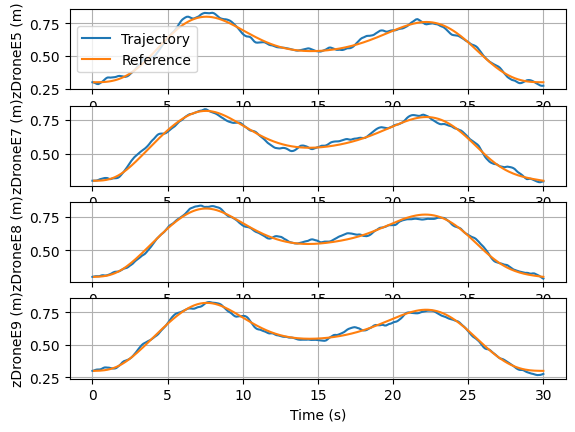

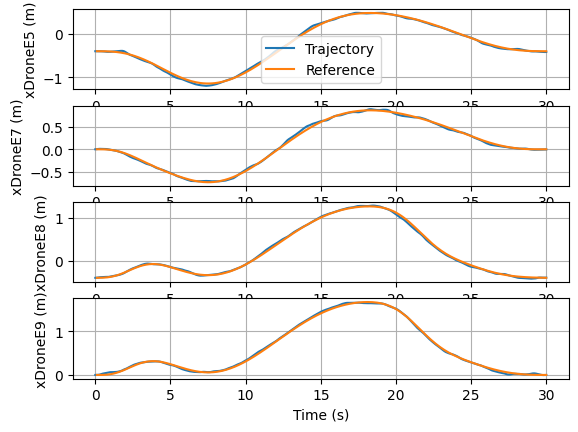

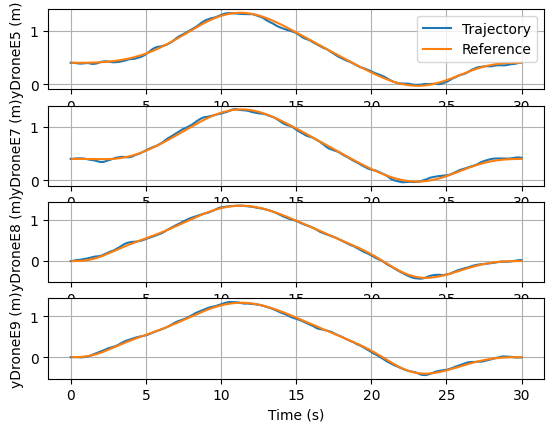

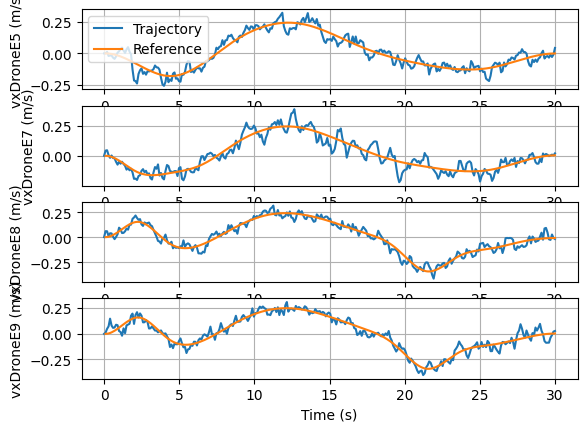

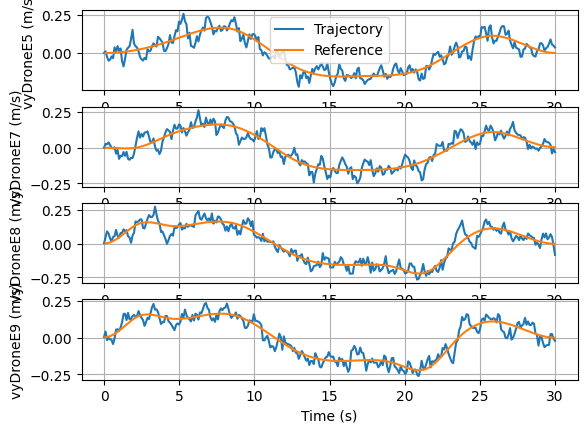

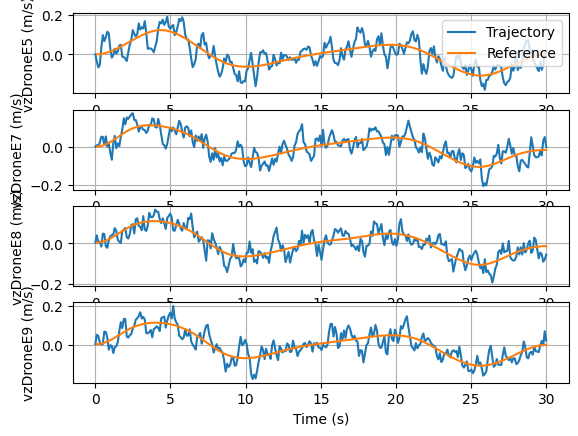

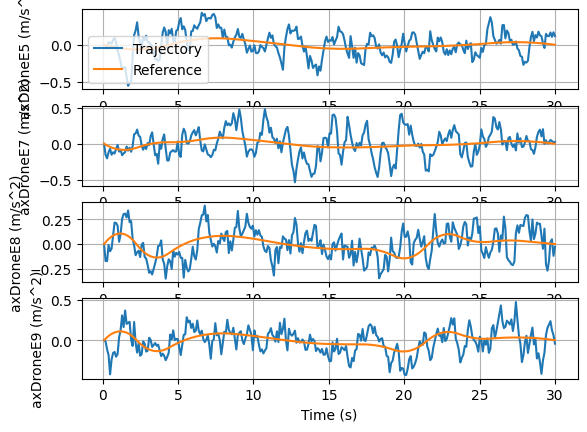

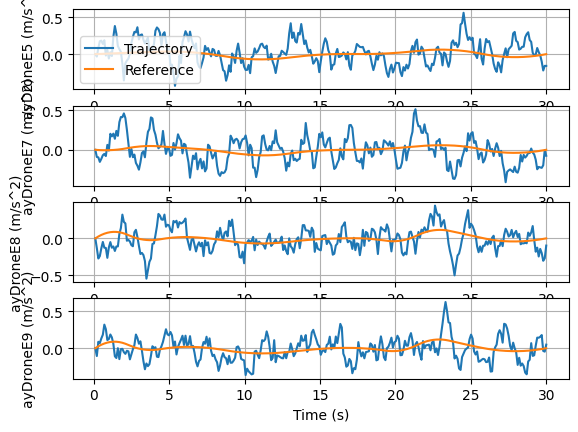

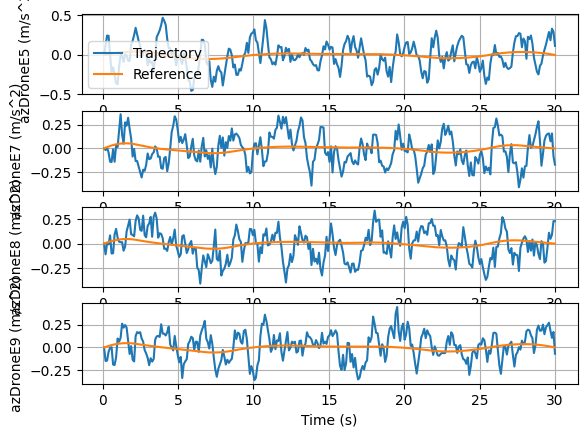

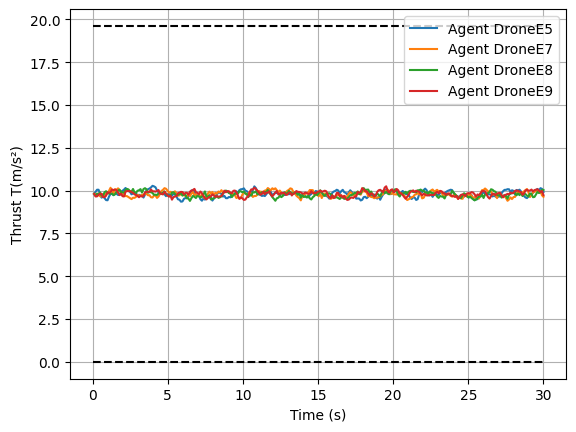

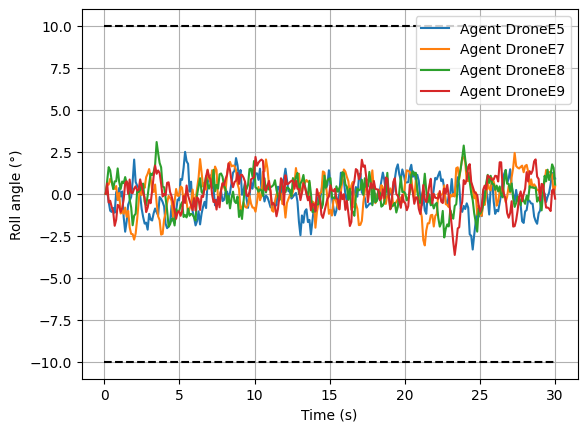

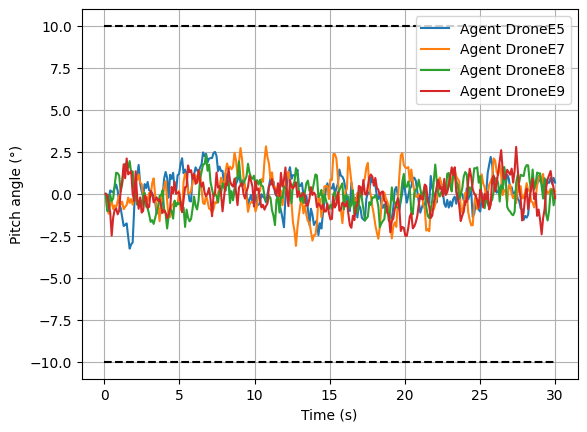

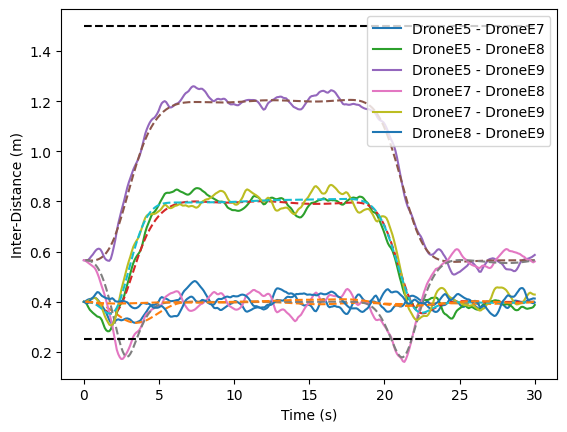

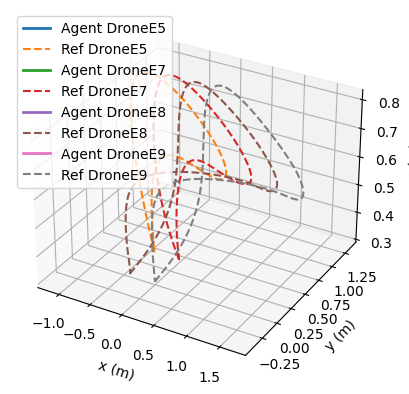

In [9]:
# plot result

import matplotlib.pyplot as plt
# import matplotlib

# Enable LaTeX formatting
# plt.rcParams.update({
#     "text.usetex":True,
#     "font.family":"sans-serif"
# })
# Plot position in 3D plot:
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')


for i in range(len(drone_bodies)):
    ax1.plot(simulator['x_sim'][0,:,i],simulator['x_sim'][1,:,i],simulator['x_sim'][2,:,i], '--')
    ax1.scatter(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2])


ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('z (m)')

ts = np.linspace(start=0,stop=Tsim,num=simulator['Nsim']+1)
fig12 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig12.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][2,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,2],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"z{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig12.savefig("./Simulation/z_MPC_tracking.eps", format='eps')
fig13 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig13.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][0,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,0],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"x{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig13.savefig("./Simulation/x_MPC_tracking.eps", format='eps')
fig14 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig14.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][1,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,1],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"y{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig14.savefig("./Simulation/y_MPC_tracking.eps", format='eps')
fig21 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig21.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][3,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,3],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vx{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig21.savefig("./Simulation/vx_MPC_tracking.eps", format='eps')
fig22 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig22.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][4,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,4],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vy{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig22.savefig("./Simulation/vy_MPC_tracking.eps", format='eps')
fig23 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig23.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][5,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,5],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vz{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig23.savefig("./Simulation/vz_MPC_tracking.eps", format='eps')
fig31 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig31.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][0,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,0],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ax{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig31.savefig("./Simulation/ax_MPC_tracking.eps", format='eps')
fig32 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig32.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][1,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,1],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ay{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig32.savefig("./Simulation/ay_MPC_tracking.eps", format='eps')
fig33 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig33.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][2,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,2],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"az{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig33.savefig("./Simulation/az_MPC_tracking.eps", format='eps')
ur = np.zeros((3,simulator['Nsim'],simulator['na']))
for k in range(simulator['Nsim']):
    for i in range(simulator['na']):
        # compute real control u
        ur[:,k,i]= ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)
        
# Create a figure and axis object
fig,ax = plt.subplots()

# plot Thrust
g = 9.81
Tmax = 2 * g
for i in range(simulator['na']):
    ax.plot(ts[1:],ur[0,:,i],label=f'Agent {drone_bodies[i]}')
    ax.grid(visible=True)

ax.plot(ts,np.ones(np.size(ts)) * Tmax,'k--',linewidth=1.5)
ax.plot(ts,np.ones(np.size(ts)) * 0,'k--',linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Thrust T(m/s²)')
ax.legend()
fig.savefig("./Simulation/Thrust_MPC_tracking.eps", format='eps')

phimax = 10 * np.pi/180
thetamax = 10 * np.pi/180

figr,axr = plt.subplots()

for i in range(simulator['na']):
    axr.plot(ts[1:],ur[1,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axr.grid(visible=True)

axr.plot(ts,np.ones(np.size(ts)) * phimax*180/np.pi,'k--',linewidth=1.5)
axr.plot(ts,np.ones(np.size(ts)) * -phimax*180/np.pi,'k--',linewidth=1.5)
axr.set_xlabel('Time (s)')
axr.set_ylabel('Roll angle (°)')
axr.legend()
figr.savefig("./Simulation/Roll_MPC_tracking.eps", format='eps')
figp,axp = plt.subplots()

for i in range(simulator['na']):
    axp.plot(ts[1:],ur[2,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axp.grid(visible=True)

axp.plot(ts,np.ones(np.size(ts)) * thetamax *180/np.pi,'k--',linewidth=1.5)
axp.plot(ts,np.ones(np.size(ts)) * -thetamax *180/np.pi,'k--',linewidth=1.5)
axp.set_xlabel('Time (s)')
axp.set_ylabel('Pitch angle (°)')
axp.legend()

# Inter-agent distance:
figid,axid = plt.subplots()
dist_max = 1.50
dist_min = 0.25
int_dist = np.zeros((simulator['Nsim']+1,simulator['na'],simulator['na']))
int_dist_ref = np.zeros((simulator['Nsim'],simulator['na'],simulator['na']))
for i in range(simulator['na']):
    for j in np.arange(i,simulator['na']):
        int_dist[:,j,i] = np.linalg.norm(simulator['x_sim'][0:3,:,i]-simulator['x_sim'][0:3,:,j],ord=2, axis=0)
        int_dist[:,i,j] = np.linalg.norm(simulator['x_sim'][0:3,:,i]-simulator['x_sim'][0:3,:,j],ord=2, axis=0)
        int_dist_ref[:,j,i] = np.linalg.norm(ref[uris[i]][:,0:3]-ref[uris[j]][:,0:3],ord=2, axis=1)
        int_dist_ref[:,i,j] = np.linalg.norm(ref[uris[i]][:,0:3]-ref[uris[j]][:,0:3],ord=2, axis=1)
for i in range(simulator['na']):
    for j in np.arange(i+1,simulator['na']):
        axid.plot(ts,int_dist[:,i,j],label=f'{drone_bodies[i]} - {drone_bodies[j]}')
        axid.plot(ts[1:],int_dist_ref[:,i,j],'--')
# print(int_dist)
axid.plot(ts,np.ones(np.size(ts)) * dist_max,'k--',linewidth=1.5)
axid.plot(ts,np.ones(np.size(ts)) * dist_min,'k--',linewidth=1.5)
axid.set_xlabel('Time (s)')
axid.set_ylabel('Inter-Distance (m)')
axid.legend()


figp.savefig("./Simulation/Pitch_MPC_tracking.eps", format='eps')
from matplotlib.animation import FuncAnimation

figani = plt.figure()
axani = figani.add_subplot(projection='3d')
for i in range(len(drone_bodies)):
    axani.plot(simulator['x_sim'][0,0,i],simulator['x_sim'][1,0,i],simulator['x_sim'][2,0,i], '-',linewidth=2,label=f'Agent {drone_bodies[i]}')
    axani.plot(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2],'--',label=f'Ref {drone_bodies[i]}')
axani.set_xlabel('x (m)')
axani.set_ylabel('y (m)')
axani.set_zlabel('z (m)')
axani.legend(loc='upper left')
def update(frame):
    axani.clear()
    for i in range(len(drone_bodies)):
        axani.plot(simulator['x_sim'][0,0:frame,i],simulator['x_sim'][1,0:frame,i],simulator['x_sim'][2,0:frame,i], '-',linewidth=2,label=f'Agent {drone_bodies[i]}')
        axani.plot(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2],'--',label=f'Ref {drone_bodies[i]}')
    axani.set_xlabel('x (m)')
    axani.set_ylabel('y (m)')
    axani.set_zlabel('z (m)')
    axani.legend(loc='upper left')
    return axani

ani = FuncAnimation(fig=figani,func=update,frames=range(1,len(simulator['x_sim'][0,:,i])),interval=50)
# ani.save('./Simulation/animation.gif',writer='Pillow')

def update_thrust(frame):
    ax.clear()
    for i in range(simulator['na']):
        ax.plot(ts[1:],ur[0,:,i],label=f'Agent {drone_bodies[i]}')
plt.show()